# Import necessary libraries

In [1]:
from saltup.ai.classification.datagenerator import ClassificationDataloader, keras_ClassificationDataGenerator, pytorch_ClassificationDataGenerator
from saltup.ai.base_dataformat.base_datagen import *
from saltup.ai.object_detection.utils.metrics import Metric
from saltup.ai.training.callbacks import BaseCallback, CallbackContext
from saltup.ai.training.app_callbacks import ClassificationEvaluationsCallback
from saltup.ai.nn_model import NeuralNetworkModel
from saltup.ai.classification.evaluate import evaluate_model
from saltup.utils.jupyter_notebook import generate_notebook_id, save_current_notebook
from saltup.ai.training.train import training
from saltup.utils.data.image.image_utils import Image, ColorMode

import zipfile
import os
import numpy as np
from torch.utils.data import DataLoader as pytorch_DataGenerator
from glob import glob
from datetime import datetime
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam

2025-07-27 19:26:36.375883: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-27 19:26:36.528375: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753637196.606207 1052522 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753637196.628302 1052522 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-27 19:26:36.788182: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
!wget --no-check-certificate https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip -O cats_and_dogs.zip

# Unzip the file using Python
with zipfile.ZipFile("cats_and_dogs.zip", "r") as zip_ref:
    extract_dir = "dataset"
    if not os.path.exists(extract_dir):
        os.makedirs(extract_dir)
    zip_ref.extractall(extract_dir)
    
    os.remove("cats_and_dogs.zip")

--2025-07-27 19:26:42--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 216.58.204.155, 142.250.180.155, 216.58.204.251, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|216.58.204.155|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘cats_and_dogs.zip’

cats_and_dogs.zip   100%[===================>]  65,43M  27,2MB/s    in 2,4s    

2025-07-27 19:26:45 (27,2 MB/s) - ‘cats_and_dogs.zip’ saved [68606236/68606236]



# Define constants

In [3]:
NUM_CLASSES = 2
BATCH_SIZE = 32
INPUT_SIZE = (128, 128)
EPOCHS = 4
EPOCH_CALLBACK_EVERY = 3
TRAIN_DATA_DIR = './dataset/cats_and_dogs_filtered/train'
TEST_DATA_DIR = './dataset/cats_and_dogs_filtered/validation'
CLASS_NAMES = ['cats', 'dogs']
CLASS_DICTIONARY = {'cats': 0, 'dogs': 1}

# Load a pre-trained model or define your own architecture

In [4]:
import torch.nn as nn
import torch.nn.functional as F

class CNN2Class(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(CNN2Class, self).__init__()

        self.conv1 = nn.Conv2d(3, 4, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(3)
        self.bn1 = nn.BatchNorm2d(4)
        self.drop1 = nn.Dropout(0.1)

        self.conv2 = nn.Conv2d(4, 8, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(3)
        self.bn2 = nn.BatchNorm2d(8)
        self.drop2 = nn.Dropout(0.1)

        self.conv3 = nn.Conv2d(8, 16, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(3)
        self.bn3 = nn.BatchNorm2d(16)
        self.drop3 = nn.Dropout(0.1)

        # Calculate the correct flattened dimension after convolutions and pooling
        # Input: (3, 128, 128)
        # After conv1 + pool1: (4, 42, 42)
        # After conv2 + pool2: (8, 14, 14)
        # After conv3 + pool3: (16, 4, 4)
        self.flat_dim = 16 * 4 * 4
        self.fc = nn.Linear(self.flat_dim, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.drop1(x)
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.drop2(x)
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = self.drop3(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)


# Data generator

In [5]:
def preprocess(image:np.ndarray, target_size:tuple) -> np.ndarray:
    """Preprocess the image by resizing and normalizing."""
    temp_image = Image(image)
    temp_image = temp_image.resize(target_size)
    img = temp_image.get_data()
    img = img / 255.0  # Normalize pixel values between [0, 1]
    return img

In [6]:
transformed_img = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.GaussianBlur(blur_limit=(3, 7), p=0.5)
   ])

In [7]:
train_dataloader = ClassificationDataloader(
    source=TRAIN_DATA_DIR,
    classes_dict=CLASS_DICTIONARY,
    img_size=(224, 224, 3)
)

test_dataloader = ClassificationDataloader(
    source=TEST_DATA_DIR,
    classes_dict=CLASS_DICTIONARY,
    img_size=(224, 224, 3)
)

In [8]:

# Create Classification Data Generator
train_gen = pytorch_ClassificationDataGenerator(
    dataloader=train_dataloader,
    target_size=INPUT_SIZE,
    num_classes=NUM_CLASSES,
    batch_size=BATCH_SIZE,
    preprocess=preprocess,
    transform=transformed_img
)


test_gen = pytorch_ClassificationDataGenerator(
    dataloader=test_dataloader,
    target_size=INPUT_SIZE,
    num_classes=NUM_CLASSES,
    batch_size=BATCH_SIZE,
    preprocess=preprocess,
    transform=None  # no augmentation
)

callbck_test_data = pytorch_DataGenerator(test_gen, batch_size=BATCH_SIZE, shuffle=False)

images, labels = next(iter(train_gen))
print("image shape", images.shape)
print("label shape", labels.shape)

image shape torch.Size([3, 128, 128])
label shape torch.Size([2])


Example image shape: torch.Size([128, 128])


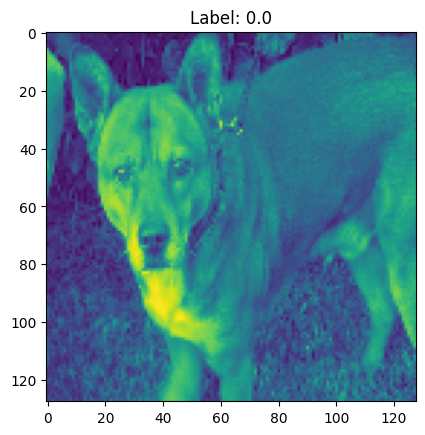

In [9]:
# Plot a single example image and its label
import matplotlib.pyplot as plt

def plot_image(image, label):
    # If image is a torch tensor, convert to numpy
    if hasattr(image, 'detach'):
        image = image.detach().cpu().numpy()
    # If image has shape (C, H, W), transpose to (H, W, C)
    if image.ndim == 3 and image.shape[0] in [1, 3]:
        image = image.transpose(1, 2, 0)
    plt.imshow(image.squeeze())
    plt.title(f"Label: {label}")
    #plt.axis('off')
    plt.show()

example_image = train_gen[0][0][0]  # Get the first image from the first batch
example_label = train_gen[0][1][0]  # Get the corresponding label
print(f"Example image shape: {example_image.shape}")
plot_image(example_image, example_label)

# Training

In [10]:
todaytime = datetime.now()
output_dir = "./training_outputs"
current_tests_folder_name = "train_{}".format(todaytime.strftime("%d-%m-%Y_%H-%M-%S"))
current_output_dir = os.path.join(output_dir, current_tests_folder_name)
if not os.path.exists(current_output_dir):
    os.makedirs(current_output_dir)
    

custom_cb = ClassificationEvaluationsCallback(
    datagen=callbck_test_data,
    end_of_train_datagen=callbck_test_data,
    every_epoch=EPOCH_CALLBACK_EVERY,
    output_file=os.path.join(current_output_dir, "classification_evaluations.txt"),
    class_names=CLASS_NAMES
)

In [11]:
torch_model = CNN2Class(num_classes=NUM_CLASSES)
optimizer =  Adam(torch_model.parameters(), lr=0.001)
loss_function = nn.CrossEntropyLoss()


kfold_parameters = {'enable':False, 'split':[0.2, 0.2, 0.2, 0.2, 0.2]}
model_name = "tiny_model"

results_dict = training(
        train_gen,
        model=torch_model,
        loss_function=loss_function,
        optimizer=optimizer,
        epochs=EPOCHS,
        output_dir=current_output_dir,
        validation_split=[0.2, 0.8],
        kfold_param =kfold_parameters,
        model_output_name = model_name,
        training_callback=[custom_cb])

PyTorch model detected.

--- Model training ---


Epoch 1/4 - loss: 0.7244 - val_loss: 0.6997 - best_epoch: 1 - best_loss: 0.7244 - best_val_loss: 0.6997
Epoch 1/4 - loss: 0.7244


Epoch 2/4 - loss: 0.6820 - val_loss: 0.7512 - best_epoch: 1 - best_loss: 0.7244 - best_val_loss: 0.6997
Epoch 2/4 - loss: 0.6820


Epoch 3/4 - loss: 0.6865 - val_loss: 0.7067 - best_epoch: 1 - best_loss: 0.7244 - best_val_loss: 0.6997
Epoch 3/4 - loss: 0.6865



                          METRICS SUMMARY FOR EPOCH 3                           
Best model epoch: 1 | Best loss: 0.7244 | Best val_loss: 0.6997
class_names: ['cats', 'dogs']

--- Evaluate PyTorch model (instance) ---


Processing data: 100%|██████████| 32/32 [00:03<00:00,  9.51it/s, accuracy=0.39, fn=439, fp=439, tp=561] 


Images processed:    1000

Per class:
++++++++++++++++++++++++++++++++++++++++++++++++++
Label              | Accuracy  
--------------------------------------------------
cats               | 0.5186    
dogs               | 0.1670    

Overall:
True Positives (TP):      561
False Positives (FP):     439
Overall Accuracy:         0.3899


Epoch 4/4 - loss: 0.6583 - val_loss: 0.7137 - best_epoch: 1 - best_loss: 0.7244 - best_val_loss: 0.6997
Epoch 4/4 - loss: 0.6583



                              METRICS ON TRAIN END                              
class_names: ['cats', 'dogs']

--- Evaluate PyTorch model (instance) ---


Processing data: 100%|██████████| 32/32 [00:03<00:00,  9.83it/s, accuracy=0.39, fn=439, fp=439, tp=561] 


Images processed:    1000

Per class:
++++++++++++++++++++++++++++++++++++++++++++++++++
Label              | Accuracy  
--------------------------------------------------
cats               | 0.5186    
dogs               | 0.1670    

Overall:
True Positives (TP):      561
False Positives (FP):     439
Overall Accuracy:         0.3899
Model successfully converted to ONNX: ./training_outputs/train_27-07-2025_19-26-46/saved_models/tiny_model_best.onnx


# Inference on test dataset


--- Evaluate PyTorch model ---


Processing data: 100%|██████████| 32/32 [00:02<00:00, 12.12it/s, accuracy=0.39, fn=439, fp=439, tp=561] 


Confusion matrix saved at ./training_outputs/train_27-07-2025_19-26-46/_pt_confusion_matrix.png


<Figure size 1000x700 with 0 Axes>

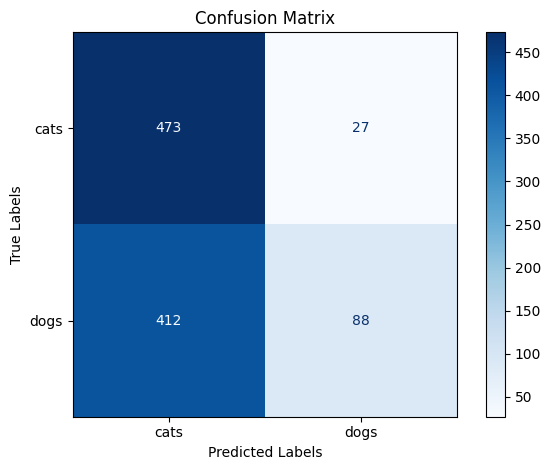

Global metrics:
FP: 439
FN: 439
Accuracy: 0.3898540653231411

Per-class metrics:
Class: cats
  FP: 412
  FN: 27
  Accuracy: 0.518640350877193
Class: dogs
  FP: 27
  FN: 412
  Accuracy: 0.16698292220113853


In [12]:
model_path = [res for res in results_dict['models_paths'] if res.endswith('.pt')][0]


global_metric, metric_per_class = evaluate_model(
    model_path, 
    test_gen=callbck_test_data,
    output_dir=current_output_dir,
    conf_matrix=True
)
print("Global metrics:")
print("FP:", global_metric.getFP())
print("FN:", global_metric.getFN())
print("Accuracy:", global_metric.getAccuracy())

print("\nPer-class metrics:")
for idx, class_name in enumerate(CLASS_NAMES):
    print(f"Class: {class_name}")
    print("  FP:", metric_per_class[idx].getFP())
    print("  FN:", metric_per_class[idx].getFN())
    print("  Accuracy:", metric_per_class[idx].getAccuracy())

In [ ]:
# Save the current notebook with the results. This is done at the end to ensure all outputs are captured.
save_current_notebook(current_output_dir)